# Top N Recommendations


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

Load the data and make sure that all of the empty strings have been filled.

In [2]:
df = pd.read_csv('logdata_6.csv',dtype=str)
df = df.fillna('None')
df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,Longitude,Latitude,LongitudeFake,LatitudeLis,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance,Speed,RSRP,RSRQ,feature7,feature8,target
0,10,20,30,40,50,1,-8.501373,51.893359,-9.152339,38.736946,-8.491719,51.893905,665.24,0,-102,-12,0,0,1
1,11,20,31,41,51,1,-8.501291,51.893462,-9.152257,38.737049,-8.491719,51.893905,658.68,1,-102,-12,0,0,1
2,11,20,31,41,51,1,-8.501291,51.893462,-9.152257,38.737049,-8.491719,51.893905,658.68,1,-102,-13,1,0,2
3,11,20,31,41,51,1,-8.501291,51.893462,-9.152257,38.737049,-8.491719,51.893905,658.68,1,-100,-12,2,1,3
4,11,20,31,41,51,1,-8.501291,51.893462,-9.152257,38.737049,-8.491719,51.893905,658.68,1,-99,-13,3,2,4


Filter out any target with less than 5 entries

In [3]:
df = df.groupby('target').filter(lambda x: len(x) >= 5)

Create dummy variables for the input features. Features 7 and 8 will be combined into one since they are both history features for the same event.

In [4]:
def seqtodict(sequence, start=0):
    #transform a sequence to a set of pairs to make into a dictionary
    n = start
    for elem in sequence:
        yield elem,n
        n += 1    

def getItemDict(itemvalues):
    itemvalues = list(itemvalues.unique())
    itemdict = {}
    if 'None' not in itemvalues:
        itemvalues = ['None'] + itemvalues
    itemdict = dict( seqtodict(itemvalues))
    return itemdict

itemdict = getItemDict(df['target'])
f1code=getItemDict(df['feature1'])
f2code=getItemDict(df['feature2'])
f3code=getItemDict(df['feature3'])
f4code=getItemDict(df['feature4'])
f5code=getItemDict(df['feature5'])
f6code=getItemDict(df['feature6'])

f61code=getItemDict(df['Longitude'])
f62code=getItemDict(df['Latitude'])
f63code=getItemDict(df['ServingCell_Lon'])
f64code=getItemDict(df['ServingCell_Lat'])
f65code=getItemDict(df['RSRP'])
f66code=getItemDict(df['RSRQ'])

def getCodeorNone(x,dictionary):
    output = 0
    try:
        output=dictionary[x]
    except:
        output=dictionary['None']
    return output

df['feature1-code'] = df['feature1'].apply(lambda x: getCodeorNone(x,f1code))
df['feature2-code'] = df['feature2'].apply(lambda x: getCodeorNone(x,f2code))
df['feature3-code'] = df['feature3'].apply(lambda x: getCodeorNone(x,f3code))
df['feature4-code'] = df['feature4'].apply(lambda x: getCodeorNone(x,f4code))
df['feature5-code'] = df['feature5'].apply(lambda x: getCodeorNone(x,f5code))
df['feature6-code'] = df['feature6'].apply(lambda x: getCodeorNone(x,f6code))

df['feature61-code'] = df['Longitude'].apply(lambda x: getCodeorNone(x,f61code))
df['feature62-code'] = df['Latitude'].apply(lambda x: getCodeorNone(x,f62code))
df['feature63-code'] = df['ServingCell_Lon'].apply(lambda x: getCodeorNone(x,f63code))
df['feature64-code'] = df['ServingCell_Lat'].apply(lambda x: getCodeorNone(x,f64code))
df['feature65-code'] = df['RSRP'].apply(lambda x: getCodeorNone(x,f65code))
df['feature66-code'] = df['RSRQ'].apply(lambda x: getCodeorNone(x,f66code))


df['feature7-code'] = df['feature7'].apply(lambda x: getCodeorNone(x,itemdict))
df['feature8-code'] = df['feature8'].apply(lambda x: getCodeorNone(x,itemdict))
df['target-code'] = df['target'].apply(lambda x: getCodeorNone(x,itemdict))

nitems = len(itemdict)

Map all of the factors to dummy columns

In [5]:
udf = pd.get_dummies(df['feature1-code'],prefix='f1')

udf = udf.join(pd.get_dummies(df['feature2-code'],prefix='f2'))
udf = udf.join(pd.get_dummies(df['feature3-code'],prefix='f3'))
udf = udf.join(pd.get_dummies(df['feature4-code'],prefix='f4'))
udf = udf.join(pd.get_dummies(df['feature5-code'],prefix='f5'))
udf = udf.join(pd.get_dummies(df['feature6-code'],prefix='f6'))

udf = udf.join(pd.get_dummies(df['feature61-code'],prefix='f61'))

udf = udf.join(pd.get_dummies(df['feature62-code'],prefix='f62'))
udf = udf.join(pd.get_dummies(df['feature63-code'],prefix='f63'))
udf = udf.join(pd.get_dummies(df['feature64-code'],prefix='f64'))
udf = udf.join(pd.get_dummies(df['feature65-code'],prefix='f65'))
udf = udf.join(pd.get_dummies(df['feature66-code'],prefix='f66'))


               
# feature 7 is the 2nd previous user click, so we weight it by 0.5
udf = udf.join(pd.get_dummies(df['feature7-code'],prefix='pre')*0.3 + pd.get_dummies(df['feature8-code'],prefix='pre'))
feature_columns = udf.columns
udf.head()

,f1_1,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f1_9,f1_10,...,pre_94,pre_95,pre_96,pre_97,pre_98,pre_99,pre_100,pre_101,pre_102,pre_103
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create test/train split

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import heapq

one_hot_labels = to_categorical(df['target-code'], num_classes=nitems)

X_train, X_test, y_train, y_test = train_test_split(udf,one_hot_labels, test_size=0.2, random_state=23)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

Using TensorFlow backend.


# Set up a Neural Network model

We use a two layer perceptron with `relu` activation and two `0.5` dropouts in between. The input dimensionality is the number of feature columns and the output is the number of target classes.

We also set up a custom scoring function that checks to see if the target class is in the top N probabilities predicted by the model.

In [7]:
def getModel(n,num_epochs=20):

    model = Sequential()
    model.add(Dense(n, activation='relu', input_dim=len(feature_columns)))
    model.add(Dropout(0.5))
    model.add(Dense(int(n/2), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nitems, activation='softmax'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    callbacks = [EarlyStopping(monitor='acc', patience=10, verbose=0),
            TQDMNotebookCallback()]
    model.fit(X_train, y_train,
              epochs=num_epochs,
              batch_size=128,verbose=0,
                 callbacks=callbacks)
    
    return model


def getScore(preds,y_test,topNvalue=10):
    
    labels = np.argmax(y_test,1)
    vals = np.argpartition(preds,-topNvalue)[:,-topNvalue:]
    score = float(vals.size - np.count_nonzero((vals.transpose() - labels).transpose()))/len(labels)
    
    return score

Run through a couple of diffent numbers of neurons, looking for the tradeoff between model size and performance.

C:\anaconda\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


C:\anaconda\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


C:\anaconda\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


C:\anaconda\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Text(0, 0.5, 'Top 10 Score')

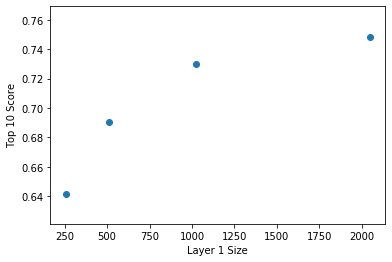

In [8]:
layer1 = [256,512,1024,2048]
scores = np.zeros(len(layer1))
num=20

for n in range(len(layer1)):
    model = getModel(layer1[n])
    preds = model.predict_proba(X_test)
    scores[n] = getScore(preds,y_test,num)
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(layer1,scores)
plt.xlabel('Layer 1 Size')
plt.ylabel('Top 10 Score')

It looks like `512` layers is decent, so we'll try that with more rounds.

In [9]:
model1=getModel(512,300)
preds = model1.predict_proba(X_test)
score=getScore(preds,y_test,num)
display(HTML('<b> Score: {}</b>'.format(score)))

C:\anaconda\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


We save the model for future predictions.

In [10]:
from keras.models import load_model

model1.save('model512.h5')  # creates a HDF5 file 'my_model.h5'
del model1  # deletes the existing model

# returns a compiled model
# identical to the previous one
model1 = load_model('model512.h5')

Finally, we check to see how the model performs if we choose the top N probabilities.

(0, 1)

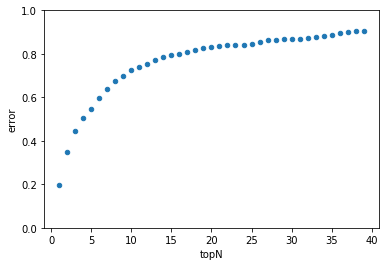

In [11]:
preds = model1.predict_proba(X_test)
score_eval = pd.DataFrame({'topN':range(1,40)})
score_eval['error'] = score_eval['topN'].apply(lambda x: getScore(preds,y_test,x))
score_eval.plot(x='topN',y='error',kind='scatter')
plt.ylim(0,1)